In [2]:
# Imports --- All of this may not be vital

# from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
# from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
import urllib.request, json
from skimage.filters import threshold_otsu
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import *
# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas
import tensorflow as tf
import pickle
import xgboost as xgb

print(tf.__version__)

2.4.0


'export' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices())


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sklearn_models = {
                 'Logistic Regression':SGDClassifier(loss='log'),
                 "Random Forest - 100 Trees":RandomForestClassifier(),
                 "Random Forest - 1000 Trees":RandomForestClassifier(n_estimators=1000),
                 "Bagging - Decision Tree": BaggingClassifier(n_estimators=100),
                 "Bagging - SVM": BaggingClassifier(base_estimator=SGDClassifier(), n_estimators=100),
                 "Bagging - Logistic Regression": BaggingClassifier(base_estimator=SGDClassifier(loss='log'), n_estimators=100),
                 "Gradient Boosting Classifier - Decision Tree": GradientBoostingClassifier(n_estimators=100),
                 "AdaBoost - Decision Tree":AdaBoostClassifier(n_estimators=100, algorithm='SAMME'),
                 "AdaBoost - Decision Tree - 1000 Estimators":AdaBoostClassifier(n_estimators=1000, algorithm='SAMME'),
                 "AdaBoost - SVM": AdaBoostClassifier(base_estimator=SGDClassifier(), n_estimators=100, algorithm='SAMME'),
                 "AdaBoost - Logistic Regression": AdaBoostClassifier(base_estimator=SGDClassifier(loss='log'), n_estimators=100, algorithm='SAMME'),
                 'XGBoost - Decision Tree':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0),
                 'XGBoost - Decision Tree - 100 Parallel Trees':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0, num_parallel_tree=100)
                 }
debug_models = {'xgb':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0, num_parallel_tree=100)}
                 #"svm": SGDClassifier(),

# Data Imports

In [4]:
### import data used to train classifiers ###

plasma_total_data_names = pd.read_excel("data/"+'gt15_plasma_features_names_biopy.xlsx', header=0, index_col=0)
csf_total_data_names = pd.read_excel("data/"+'gt15_csf_features_names_biopy.xlsx', header=0,index_col=0)

## sort into names and features
features_plasma = plasma_total_data_names.copy()
features_plasma = features_plasma.drop(['Corona'], axis=1)
names_plasma = plasma_total_data_names['Corona'].copy()

features_csf = csf_total_data_names.copy()
features_csf = features_csf.drop(['Corona'], axis=1) 
names_csf = csf_total_data_names['Corona'].copy()

### create a merged set
features_plasma_labeled = features_plasma.copy()
features_csf_labeled = features_csf.copy()

features_plasma_labeled['phase_plasma'] = 1
features_csf_labeled['phase_plasma'] = 0

features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
names_merged = names_plasma.append(names_csf, ignore_index=True)

# set with no phase labeling names are identical to names merged
features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

# print(plasma_total_data_names.shape, csf_total_data_names.shape, features_test.shape) ## in case you need to see shapes

## there is a known error here, sometimes there is an Unnamed column just drop it code is available in a 
#lower cell (scaling cell), its a holdover from two merged sets



In [4]:
## Use this space to import test data ### 

features_test = pd.read_excel('complete_test_features_biopy.xlsx', header=0, index_col = 0)
features_test = features_test.append(pd.read_excel('complete_test_features_biopy_v2.xlsx', header=0, index_col = 0))

features_verification = pd.read_excel('complete_verification_features_biopy_covid.xlsx', header=0, index_col = 0)
#features_test = features_test.drop(['Protein names'], axis=1)

In [5]:
scaler = MinMaxScaler()
total_data = features_merged_naive.copy()  ## for a regular netsurfp included case
# total_data = subset_features.copy() ### for a subset case --- use this one
total_data = total_data.fillna(0)
total_data_with_names = total_data.copy()
total_data = total_data.drop(['Protein names'], axis=1)
scaler = scaler.fit(total_data)
scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)
print(scaled_df.shape)

# total_data_labeled = features_merged.copy()
# total_data_labeled = total_data_labeled.fillna(0)
# total_data_labeled = total_data_labeled.drop(['Protein names'], axis=1)
# scaled_df_total = pd.DataFrame(scaler.transform(total_data_labeled), columns=total_data_labeled.columns)

scaled_df_phase = scaled_df.copy()
scaled_df_phase['phase_plasma'] = features_merged['phase_plasma'].copy()

plasma_data = scaled_df_phase[scaled_df_phase.phase_plasma==1]
plasma_data = plasma_data.drop(['phase_plasma'], axis=1)
scaled_df_plasma = plasma_data #pd.DataFrame(scaler.transform(plasma_data), columns=plasma_data.columns)

csf_data = scaled_df_phase[scaled_df_phase.phase_plasma==0]
csf_data = csf_data.drop(['phase_plasma'], axis=1)
scaled_df_csf = csf_data #pd.DataFrame(scaler.transform(csf_data), columns=csf_data.columns)

#### UNCOMMENT this section for a REGULAR RUN
# #features = features_merged_naive.copy()  # change the dataframe that you want to use here
# features_test = features_test.fillna(0)
# features_test_names = features_test.copy()
# features_test = features_test.drop(['Protein names'], axis=1)
# scaled_test_df = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)


scaled_df = scaled_df.drop(['Unnamed: 0.1'], axis=1)
# scaled_test_df = scaled_test_df.drop(['Unnamed: 0.1'], axis=1)

(174, 90)


In [5]:
fig5_data = scaled_df.copy()
fig5_data['In Corona'] = names_merged
fig5_data.to_excel("data_for_fig_5_netsurfp2.xlsx")

In [12]:
#### SCALE DATA THAT IS FROM 

scaled_features_for_prediction = pd.DataFrame(scaler.transform(features_for_prediction.copy().drop(['Protein names'], axis=1)), 
                                             columns=features_for_prediction.drop(['Protein names'], axis=1).columns)

NameError: name 'features_for_prediction' is not defined

In [6]:
### Data put into classifier and classified


df_local_features_train = scaled_df.copy()
# df_local_protein_names_train = features_test_names['Protein names']
df_local_names = names_merged.copy()

# df_local_features_classify = scaled_features_for_prediction.copy()
# df_local_protein_names_classify = features_for_prediction['Protein names'].copy()

### to keep some things kosher later
df_local_features_train_copy = scaled_df.copy()
df_local_names_copy = names_merged.copy()
# df_local_features_classify_copy = df_local_features_classify.copy()
# df_local_protein_names_classify_copy = df_local_protein_names_classify.copy()

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((scaled_df.values, names_merged.values))
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ), feat.shape)


Features: [0.45723963 0.56114304 0.3003424  0.47103555 0.74679113 0.01088629
 0.20898642 0.18697794 0.81122852 0.52293406 0.24233716 0.38305054
 0.1774949  0.30244014 0.2839351  0.12858852 0.37503024 0.44200661
 0.07586207 0.49862239 0.11592718 0.59240282 0.38911963 0.47555165
 0.54441963 0.49338039 0.47016706 0.43084523 0.44879852 0.27697488
 0.6072715  0.01585148 0.61673666 0.63718578 0.11424731 0.11592799
 0.5007657  0.4992343  0.25995306 0.3273452  0.40192926 0.45920746
 0.82291667 0.10018236 0.52920947 0.         0.36379168 0.44388437
 0.2060009  0.01191671 0.1481681  0.03980522 0.81206034 0.28463847
 0.17804363 0.39162562 0.16094168 0.23223082 0.28350912 0.17318158
 0.41773399 0.43493432 0.         0.28571429 0.59377331 0.
 0.39806432 0.69392751 0.24208376 0.02557345 0.18008251 0.05114297
 0.88661337 0.3271019  0.16733547 0.3005618  0.14387057 0.2929374
 0.28143472 0.1488764  0.45692884 0.53177669 0.         0.27106742
 0.40406342], Target: 0 (85,)
Features: [0.26853756 0.2885878

In [8]:
### create tensorflow datasets


## Classifier

In [ ]:
k_fold_splits = 15
predictions = pd.DataFrame()
scaler = MinMaxScaler()


feature_imp = pd.DataFrame(columns=list(scaled_df.columns))
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

# #split up our data
i = 0
skf = KFold(n_splits=k_fold_splits, shuffle=True)

for train_index, test_index in skf.split(df_local_features_train, df_local_names):
    X_train = df_local_features_train.iloc[train_index]
    X_test = df_local_features_train.iloc[test_index]
    y_train = df_local_names.iloc[train_index]
    y_test = df_local_names.iloc[test_index]


    
    # Create and Train
    rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=35, warm_start=False, 
                               n_estimators=110, min_samples_split=4, min_samples_leaf= 2, max_features= 'log2', max_depth = 10)
    
    sme = SMOTE(random_state=35, sampling_strategy=.6, n_jobs=-1, k_neighbors=7)
    X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        
    rfc.fit(X_train_oversampled,y_train_oversampled)
#     rfc.fit(X_train,y_train)

    

    if first_frame:  # Initialize 
        first_frame = False  # Don't Come back Here
        
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        
        correctness_frame = pd.DataFrame(data=datadict)
        correctness_frame['round'] = i

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        
        metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
        metrics_frame['Round'] = i

        predictions = pd.DataFrame()
        predictions['Protein Name'] = df_local_protein_names_classify
        predictions['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        predictions['Round'] = i
        predictions['Test Accuracy'] = metrics_dict['Accuracy']
        predictions['Test Recall'] = metrics_dict['Recall']
        predictions['Test Precision'] = metrics_dict['Precision']
        predictions['Test AUC'] = metrics_dict['AUC']

        
    else:
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        revolve_frame = pd.DataFrame(data=datadict)
        revolve_frame['round'] = i
        correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
        metrics_revolve_frame['Round'] = i
        metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)

        pred_rev = pd.DataFrame()
        pred_rev['Protein Name'] = df_local_protein_names_classify
        pred_rev['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        pred_rev['Round'] = i
        pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
        pred_rev['Test Recall'] = metrics_dict['Recall']
        pred_rev['Test Precision'] = metrics_dict['Precision']
        pred_rev['Test AUC'] = metrics_dict['AUC']

        predictions = predictions.append(pred_rev, ignore_index=True)


    
    feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
    
    i += 1

# Tensorflow Trial

## Tensorflow Trial 1

In [72]:

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy', tf.keras.metrics.Precision()])
  return model


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [62]:
with tf.device('/cpu:0'):
  METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
  ]


  def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(85,), kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid',
                          bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

    
  def make_model_small(metrics=METRICS, output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(85,), kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid',
                          bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

  def make_model_large(metrics=METRICS, output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(85,), kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid',
                          bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [63]:
model = make_model_small().build()
model.summary()

AttributeError: 'NoneType' object has no attribute 'summary'

In [67]:
tf.keras.backend.set_floatx('float64')

k_fold_splits = 1
predictions = pd.DataFrame()
scaler = MinMaxScaler()

acc_arry=np.zeros(k_fold_splits)
prec_arry=np.zeros(k_fold_splits)
roc_arry=np.zeros(k_fold_splits)
recall_arry=np.zeros(k_fold_splits)
choice_data = {}

feature_imp = pd.DataFrame(columns=list(scaled_df.columns))
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

# #split up our data
i = 0
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=35)
# skf = StratifiedKFold(n_splits=k_fold_splits, shuffle=True)

for train_index, test_index in sss.split(df_local_features_train, df_local_names):
    print(f'Round {i} \n')
    with tf.device('/cpu:0'):
        X_train = df_local_features_train.iloc[train_index]
        X_test = df_local_features_train.iloc[test_index]
        y_train = df_local_names.iloc[train_index]
        y_test = df_local_names.iloc[test_index]
        # print(X_train.shape)
        sme = SMOTE(random_state=35, sampling_strategy=.6, n_jobs=-1, k_neighbors=7)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_oversampled.values, y_train_oversampled.values)).batch(1)
        # train_2 = train_dataset.shuffle(len(X_train)).batch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(1)

        model=make_model_large()
        model.fit(train_dataset, epochs=10, verbose=0)
        results = model.evaluate(test_dataset)

        # acc_arry[i] = results[1]
        # prec_arry[i] = results[2]
        # roc_arry[i] = results[4]
        # recall_arry[i] = results[3]
        # choice_data['Round '+str(i)] = results[5:]

        # print(results)
        i += 1
# print(type(train_dataset), type(train_2))
model.summary()

Round 0 

18/18 [==============================] - 1s 4ms/step - loss: 0.8770 - accuracy: 0.4444 - precision: 0.3000 - recall: 0.5000 - auc: 0.3681 - tp: 3.0000 - fp: 7.0000 - tn: 5.0000 - fn: 3.0000
Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_492 (Dense)            (None, 512)               44032     
_________________________________________________________________
dropout_365 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_493 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_366 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_494 (Dense)            (None, 512)               262656    
__________________________________________________

In [16]:
print(choice_data) # loss, accuracy, precision, 
print(acc_arry)
# classifier_data = {}
# mean_classifier_data = {}

{'Round 0': [17.0, 12.0, 46.0, 12.0], 'Round 1': [6.0, 3.0, 55.0, 23.0]}
[0.7241379 0.7011494]


In [148]:
classifier_data['no smote - l2 .00001 - large net - stratified kfold'] = {'accuracy':acc_arry, 'precision':prec_arry, 'recall':recall_arry, 'auc':roc_arry}
mean_classifier_data['no smote - l2 .00001 - large net - stratified kfold'] = {'accuracy':acc_arry.mean(), 'precision':prec_arry.mean(), 'recall':recall_arry.mean(), 'auc':roc_arry.mean()}

In [29]:
mednet_data=pd.DataFrame()
mednet_data["Accuracy"] = acc_arry
mednet_data['Precision'] = prec_arry
mednet_data['Recall'] = recall_arry
mednet_data['F1'] = 2 * (mednet_data['Precision'] * mednet_data['Recall']) / (mednet_data['Precision'] + mednet_data['Recall'])
mednet_data['AUC'] = roc_arry
mednet_data['Round'] = np.arange(0, 100, 1)
mednet_data['Classifier'] = 'Neural Net - Medium'

In [31]:
mednet_data.to_excel('medium_neural_net_data.xlsx')

In [149]:
pprint(mean_classifier_data)

{'no smote': {'accuracy': 0.6722222222222222,
              'auc': 0.6065850970017637,
              'precision': 0.06666666666666667,
              'recall': 0.013333333333333334},
 'no smote - l2 .000001': {'accuracy': 0.7348484848484848,
                           'auc': 0.7149134199134198,
                           'precision': 0.5977777777777777,
                           'recall': 0.363968253968254},
 'no smote - l2 .00001': {'accuracy': 0.751010101010101,
                          'auc': 0.755698452781786,
                          'precision': 0.7222222222222221,
                          'recall': 0.42777777777777787},
 'no smote - l2 .00001 - elu': {'accuracy': 0.758080808080808,
                                'auc': 0.7202314814814815,
                                'precision': 0.6011111111111112,
                                'recall': 0.39222222222222225},
 'no smote - l2 .00001 - large net': {'accuracy': 0.7989898989898988,
                                      'au

In [150]:


with open('neural_net_data.pickle', 'wb') as handle:
    pickle.dump(classifier_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('mean_neural_net_data.pickle', 'wb') as handle:
    pickle.dump(mean_classifier_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
### Pandas test

with open('neural_net_data.pickle', 'rb') as handle:
    b = pickle.load(handle)




,accuracy,precision,recall,auc
no smote,"[0.75, 0.6666666666666666, 0.8333333333333334,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9074074074074074, 0.30000000000000004, 0.5,..."
smote,"[0.6666666666666666, 0.4166666666666667, 0.75,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, ...","[0.5, 0.5, 0.5185185185185185, 0.5, 0.5, 0.5, ..."
no smote - l2 .0001,"[0.75, 0.5833333333333334, 0.6666666666666666,...","[1.0, 0.5, 0.5, 1.0, 0.5, 0.6666666666666666, ...","[0.25, 0.4, 0.5, 0.2857142857142857, 0.4, 0.8,...","[0.5, 0.5142857142857142, 0.625, 0.84285714285..."
no smote - l2 .00001,"[0.9166666666666666, 0.5833333333333334, 0.833...","[0.6666666666666666, 0.5, 1.0, 0.75, 1.0, 0.0,...","[1.0, 0.2, 0.5, 1.0, 0.6, 0.0, 0.4, 0.6, 0.25,...","[1.0, 0.2285714285714286, 0.875, 0.92592592592..."
no smote - l2 .000001,"[0.5, 0.9166666666666666, 0.75, 0.666666666666...","[1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, ...","[0.14285714285714285, 0.6666666666666666, 0.5,...","[0.6428571428571428, 0.7777777777777777, 0.7, ..."
smote - l2 .00001,"[0.75, 0.6666666666666666, 0.5833333333333334,...","[0.5, 0.4, 0.5714285714285714, 0.3333333333333...","[0.6666666666666666, 0.6666666666666666, 0.666...","[0.7222222222222221, 0.7407407407407407, 0.611..."
no smote - l2 .00001 - elu,"[0.6666666666666666, 0.6666666666666666, 0.833...","[0.0, 0.0, 1.0, 0.75, 0.0, 0.0, 1.0, 0.6666666...","[0.0, 0.0, 0.5, 0.75, 0.0, 0.0, 0.5, 0.6666666...","[0.4629629629629629, 0.375, 0.65625, 0.90625, ..."
no smote - l2 .00001 - small net,"[0.6666666666666666, 0.8333333333333334, 0.833...","[0.0, 0.5, 1.0, 1.0, 0.75, 0.6666666666666666,...","[0.0, 0.5, 0.3333333333333333, 0.5, 0.5, 0.5, ...","[0.6875, 0.7999999999999999, 0.574074074074074..."
no smote - l2 .00001 - large net,"[0.8333333333333334, 1.0, 0.8333333333333334, ...","[0.6666666666666666, 1.0, 1.0, 1.0, 0.6, 1.0, ...","[0.6666666666666666, 1.0, 0.6666666666666666, ...","[0.6296296296296295, 1.0, 0.9027777777777778, ..."
no smote - l2 .00001 - small net - stratified kfold,"[0.75, 0.5833333333333334, 0.8333333333333334,...","[0.6666666666666666, 0.0, 1.0, 1.0, 0.0, 0.5, ...","[0.5, 0.0, 0.5, 0.75, 0.0, 0.25, 0.5, 0.5, 0.2...","[0.734375, 0.5, 0.9375, 0.875, 0.6875, 0.6875,..."


# Other Non Deep Learning Networks  

In [7]:
k_fold_splits = 100
predictions = pd.DataFrame()
scaler = MinMaxScaler()
first_frame = True
metrics_frame = pd.DataFrame()
for key, model in sklearn_models.items():
    print(key)
    acc_arry=np.zeros(k_fold_splits)
    prec_arry=np.zeros(k_fold_splits)
    roc_arry=np.zeros(k_fold_splits)
    recall_arry=np.zeros(k_fold_splits)
    choice_data = {}

    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))
    
    correctness_frame = pd.DataFrame()
    

    # #split up our data
    i = 0


    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.1, random_state=2020)
    # skf = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=35)

    for train_index, test_index in sss.split(df_local_features_train, df_local_names):
        # print(f'Round {i} \n')
        X_train = df_local_features_train.iloc[train_index]
        X_test = df_local_features_train.iloc[test_index]
        y_train = df_local_names.iloc[train_index]
        y_test = df_local_names.iloc[test_index]
        # print(X_train.shape)
        sme = SMOTE(random_state=2020, sampling_strategy=.5, n_jobs=-1, k_neighbors=20)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        
        if key == 'meta':
            rfc = RandomForestClassifier()
            rfc.fit(X_train_oversampled, y_train_oversampled)
            X_train_oversampled['meta_feat'] = rfc.predict_proba(X_train_oversampled)[:, 1]
            print(X_train_oversampled.shape, y_train_oversampled.shape)
            model.fit(X_train_oversampled, y_train_oversampled)
            X_test['meta_feat'] = rfc.predict_proba(X_test)[:, 1]
        
        else:
            model.fit(X_train_oversampled, y_train_oversampled)

        

        if first_frame:  # Initialize 
            print("first frame")
            first_frame = False  # Don't Come back Here
            
            # datadict = {'true':y_test.to_numpy(), 'estimate':model.predict(X_test), 'probability':model.predict_proba(X_test)[:, 1]}
            
            # correctness_frame = pd.DataFrame(data=datadict)
            # correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'Accuracy':model.score(X_test, y_test), 'Recall':recall_score(y_test, model.predict(X_test)), 
            'Precision':precision_score(y_test, model.predict(X_test)), 'F1':f1_score(y_test, model.predict(X_test))}
            
            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['Round'] = i
            metrics_frame['Classifier'] = key

            
        else:
            # datadict = {'true':y_test.to_numpy(), 'estimate':model.predict(X_test), 'probability':model.predict_proba(X_test)[:, 1]}
            # revolve_frame = pd.DataFrame(data=datadict)
            # revolve_frame['round'] = i
            # correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'Accuracy':model.score(X_test, y_test), 'Recall':recall_score(y_test, model.predict(X_test)), 
            'Precision':precision_score(y_test, model.predict(X_test)), 'F1':f1_score(y_test, model.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['Round'] = i
            metrics_revolve_frame['Classifier'] = key
            metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)

            # print(results)
        i += 1

Logistic Regression
first frame
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Random Forest - 100 Trees
Random Forest - 1000 Trees
Bagging - Decision Tree
Bagging -

In [8]:
metrics_frame.to_excel('non_nn_clasifier_data.xlsx')

In [59]:
dnn_data = pd.DataFrame()
dict_for_plotting = {"small net": b["no smote - l2 .00001 - small net - stratified kfold"],
                    "medium net": b["no smote - l2 .00001 - medium net - stratified kfold"],
                    "large net": b["no smote - l2 .00001 - large net - stratified kfold"]
}

for key, value in dict_for_plotting.items():
    print(key)
    temp_df = pd.DataFrame.from_dict(data=dict_for_plotting[key], orient='index').transpose()
    temp_df['Classifier'] = key
    temp_df['Round'] = np.arange(0, 15)
    temp_df['F1'] = 2 * (temp_df['precision'] * temp_df['recall']) / (temp_df['precision'] + temp_df['recall'])
    dnn_data = dnn_data.append(temp_df, ignore_index=True)

dnn_data = dnn_data.rename(columns = {'precision':'Precision', 'accuracy':'Accuracy', 'recall':'Recall', 'auc':'AUC'})
dnn_data_melt = pd.melt(dnn_data, id_vars=["Round", "Classifier"])

small net
medium net
large net


In [42]:
def calculate_f1(prec, recall):
    return 2 * (prec * recall) / (prec + recall)

large_net = pd.read_excel('big_neural_net_data.xlsx', header=0, index_col=0)
large_net['F1'] = calculate_f1(large_net.Precision, large_net.Recall)

medium_net = pd.read_excel('medium_neural_net_data.xlsx', header=0, index_col=0)
medium_net['F1'] = calculate_f1(medium_net.Precision, medium_net.Recall)

small_net = pd.read_excel('small_neural_net_data.xlsx', header=0, index_col=0)
small_net['F1'] = calculate_f1(small_net.Precision, small_net.Recall)

metrics_frame = metrics_frame.append([large_net, medium_net, small_net])

In [9]:
melted_metrics_frame = pd.melt(metrics_frame, id_vars=["Round", "Classifier"])

In [52]:
metrics_frame.to_excel("Multi_classifier_comparison.xlsx")

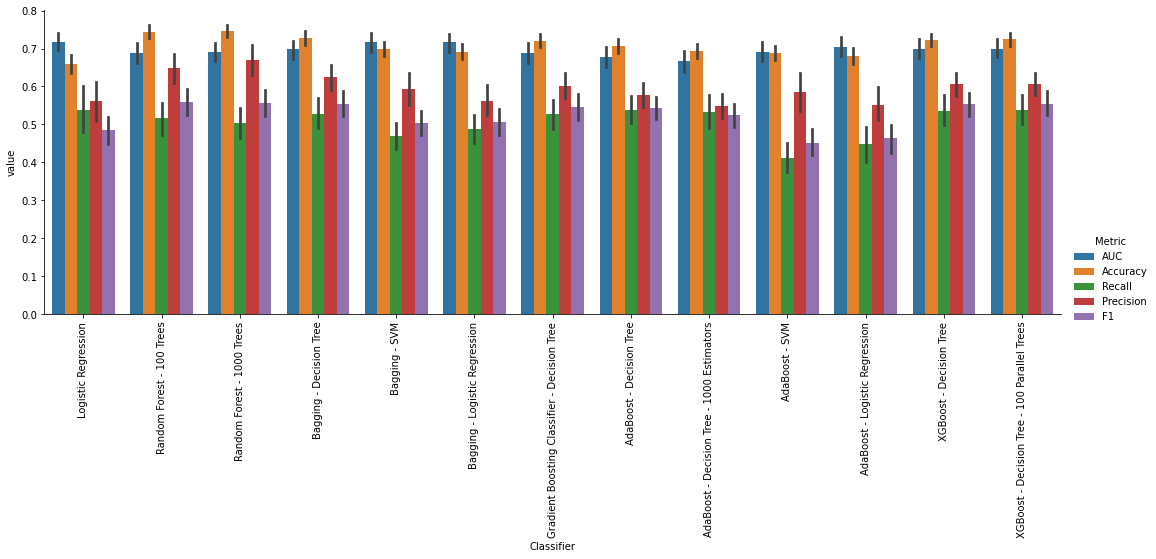

In [10]:
melted_metrics_frame = melted_metrics_frame.rename(columns={'variable':'Metric'})

ax = sns.catplot(data=melted_metrics_frame, kind="bar", x="Classifier", y="value", hue="Metric", height=5, aspect=3)
ax.set_xticklabels(rotation=90)
plt.show()

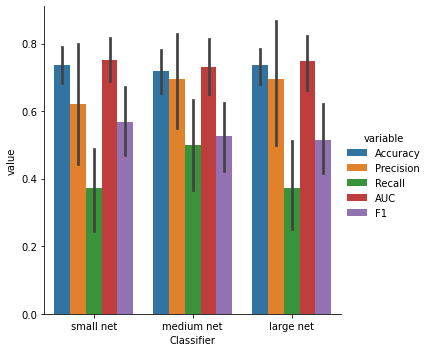

In [60]:
ax = sns.catplot(data=dnn_data_melt, kind="bar", x="Classifier", y="value", hue="variable", height=5, aspect=1)

plt.show()

In [97]:
# X_train_oversampled
np.random.randint(2, size=4)
dtrain = xgb.DMatrix(X_train_oversampled.values, label=y_train_oversampled)
dtest = xgb.DMatrix(X_test.values, label=y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}

param['eval_metric'] = 'aucpr'

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-aucpr:0.57651	train-aucpr:0.98636
[1]	eval-aucpr:0.57651	train-aucpr:0.98636
[2]	eval-aucpr:0.57651	train-aucpr:0.98636
[3]	eval-aucpr:0.57651	train-aucpr:0.98636
[4]	eval-aucpr:0.57651	train-aucpr:0.98636
[5]	eval-aucpr:0.59892	train-aucpr:0.98636
[6]	eval-aucpr:0.55616	train-aucpr:0.98636
[7]	eval-aucpr:0.52942	train-aucpr:0.98636
[8]	eval-aucpr:0.57189	train-aucpr:0.98636
[9]	eval-aucpr:0.53145	train-aucpr:0.98636


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

## Grid Search CV